### Import data

In [5]:
include("importData.jl")
include("ODEmodel.jl")


# import data from the path
pop, g2, g1, g1_0, g2_0 = get_data("..//data//lap.csv", "..//data//lap_pop.csv"); # in which:
# pop: population data
# g1, g2: g1 and g2 data
# initial: initial number of cells in g1 and in g2 at time 0

# This is to load the estimated parameters to be used as "initial guess"
param_lap_ode = CSV.read(".//figures//Lapatinib//params_lap_ODE.csv")

# initial guesses for the parameters
lap = convert(Matrix, param_lap_ode[1:4,2:end]); 

### Estimate 

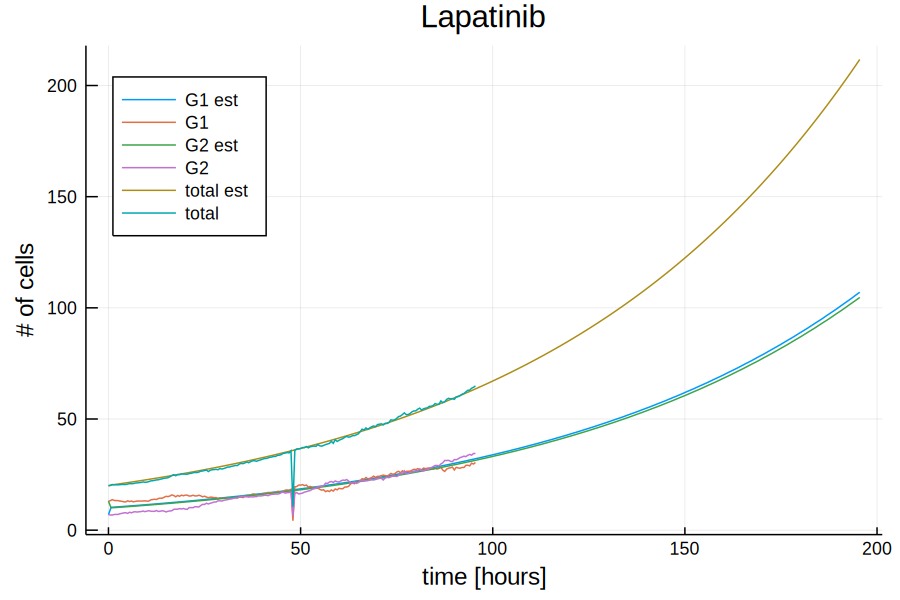

In [6]:
# i is the number of the column we are using from the data (# of trial)
i = 3

# initial guess
p  = lap[:, i]

# setting lowest delay for tau1 to be half an hour and for tau2 to be 3 hours.
low = 0.05*ones(4)
upp = 20*ones(4)

# Estimating the parameters for trial i
params = optimIt(p, low, upp, i, g1, g2)

# Plotting the long-term prediction along with the data for trial i
plotIt(params, g1, g2, g1_0, g2_0, pop, i, "Lapatinib")